# Notebook 2: Quick Pipeline - Pre-computed Heart Rate Analysis

## Overview

In this notebook, we'll use **pre-computed heart rate** data for rapid analysis. This approach is ideal for:

- **Real-time applications**: Quick feedback during experiments
- **Neurophenomenology studies**: Immediate insights into physiological states
- **Exploratory analysis**: Fast initial assessment before deep analysis
- **Prototyping**: Testing synchrony methods quickly

### Advantages:
- Fast computation (seconds vs. minutes)
- No ECG preprocessing needed
- Simple to implement
- Good for real-time applications

### Limitations:
- Less granular than R-peak based analysis
- Cannot compute detailed HRV metrics
- Potential loss of beat-to-beat variability information
- Dependent on sensor's pre-processing quality

---

## 1. Setup and Load Data

In [1]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, stats
from pathlib import Path
import json

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print(" Libraries imported successfully!")

 Libraries imported successfully!


In [2]:
# Load processed data from Notebook 1
data_dir = Path("processed_data")

# Load metadata
with open(data_dir / 'metadata.json', 'r') as f:
    metadata = json.load(f)

# Load heart rate data from Notebook 3 (R-peak based)
hr_p1 = pd.read_csv(data_dir / f"hr_{metadata['participant_1']}.csv")
hr_p2 = pd.read_csv(data_dir / f"hr_{metadata['participant_2']}.csv")

print(" Data loaded successfully!")
print(f"\nParticipant 1 ({metadata['participant_1']}): {len(hr_p1)} HR samples")
print(f"Participant 2 ({metadata['participant_2']}): {len(hr_p2)} HR samples")
print(f"\nExperiment duration: {metadata['duration_seconds']:.1f} seconds")

 Data loaded successfully!

Participant 1 (Participant_A): 871 HR samples
Participant 2 (Participant_B): 1028 HR samples

Experiment duration: 544.0 seconds


## 2. Understanding the HR Data Structure

The pre-computed HR files contain two columns:

- **Average**: Heart rate in beats per minute (BPM)
- **RRData**: RR interval (inter-beat interval) in milliseconds

### Key Terminology:

**Heart Rate (HR)**: Number of heartbeats per minute
- Normal resting: 60-100 BPM
- Lower in athletes, higher during stress/exercise

**RR Interval / IBI (Inter-Beat Interval)**: Time between consecutive heartbeats
- Measured in milliseconds
- Inversely related to HR: `HR = 60,000 / RR_interval`

**Note**: The HR file doesn't include timestamps, so we'll need to create them based on the data points and experiment duration.

In [3]:
# Display first few rows
print("Sample HR data structure:")
print(hr_p1.head(10))

# Basic statistics
print(f"\n📊 {metadata['participant_1']} HR Statistics:")
print(f"   Mean HR: {hr_p1['Average'].mean():.1f} BPM")
print(f"   Std HR:  {hr_p1['Average'].std():.1f} BPM")
print(f"   Range:   {hr_p1['Average'].min():.1f} - {hr_p1['Average'].max():.1f} BPM")

print(f"\n📊 {metadata['participant_2']} HR Statistics:")
print(f"   Mean HR: {hr_p2['Average'].mean():.1f} BPM")
print(f"   Std HR:  {hr_p2['Average'].std():.1f} BPM")
print(f"   Range:   {hr_p2['Average'].min():.1f} - {hr_p2['Average'].max():.1f} BPM")

Sample HR data structure:
      Average  RRData
0  153.061220     392
1   73.700005     808
2   74.500000     784
3   74.700005     800
4   75.500000     776
5   75.800000     784
6   76.500000     768
7   75.400000     824
8   75.100000     808
9   75.100000     800

📊 Participant_A HR Statistics:
   Mean HR: 98.4 BPM
   Std HR:  20.1 BPM
   Range:   71.3 - 153.1 BPM

📊 Participant_B HR Statistics:
   Mean HR: 115.8 BPM
   Std HR:  21.5 BPM
   Range:   85.6 - 167.6 BPM


## 3. Creating Time Series with Timestamps

Since the HR data doesn't have timestamps, we'll create them by distributing the samples evenly across the experiment duration.

In [4]:
def create_timestamps_for_hr(hr_df, start_time, end_time):
    """
    Create timestamps for HR data based on RR intervals.
    
    Each row in the HR data represents a heartbeat. The RRData column contains
    the inter-beat interval (time between beats) in milliseconds.
    
    Parameters:
    - hr_df: DataFrame with HR data (must have 'RRData' column)
    - start_time: Experiment start timestamp
    - end_time: Experiment end timestamp (used for validation)
    
    Returns:
    - DataFrame with added 'Timestamp' and 'Time_s' columns
    """
    df = hr_df.copy()
    
    # Convert RR intervals from milliseconds to seconds
    rr_intervals_sec = df['RRData'].values / 1000.0
    
    # Create timestamps by cumulatively adding RR intervals
    # The first timestamp is at the start time
    # Each subsequent timestamp is previous timestamp + RR interval
    timestamps = np.zeros(len(df))
    timestamps[0] = start_time
    
    for i in range(1, len(df)):
        timestamps[i] = timestamps[i-1] + rr_intervals_sec[i]
    
    df['Timestamp'] = timestamps
    
    # Create relative time in seconds (starting from 0)
    df['Time_s'] = df['Timestamp'] - start_time
    
    # Calculate actual duration and sampling info
    actual_duration = timestamps[-1] - timestamps[0]
    mean_hr_sampling_rate = len(df) / actual_duration
    
    print(f"  Samples (heartbeats): {len(df)}")
    print(f"  Duration from RR intervals: {actual_duration:.2f} seconds")
    print(f"  Expected duration: {end_time - start_time:.2f} seconds")
    print(f"  Mean heart rate: {df['Average'].mean():.1f} BPM")
    print(f"  Mean RR interval: {df['RRData'].mean():.0f} ms")
    print(f"  Average sampling rate: {mean_hr_sampling_rate:.3f} Hz")
    
    return df

# Add timestamps to HR data based on actual RR intervals
print(f"Creating timestamps for {metadata['participant_1']}:")
hr_p1_ts = create_timestamps_for_hr(
    hr_p1, 
    metadata['exp_start'], 
    metadata['exp_end']
)

print(f"\nCreating timestamps for {metadata['participant_2']}:")
hr_p2_ts = create_timestamps_for_hr(
    hr_p2, 
    metadata['exp_start'], 
    metadata['exp_end']
)

Creating timestamps for Participant_A:
  Samples (heartbeats): 871
  Duration from RR intervals: 551.92 seconds
  Expected duration: 543.99 seconds
  Mean heart rate: 98.4 BPM
  Mean RR interval: 634 ms
  Average sampling rate: 1.578 Hz

Creating timestamps for Participant_B:
  Samples (heartbeats): 1028
  Duration from RR intervals: 549.33 seconds
  Expected duration: 543.99 seconds
  Mean heart rate: 115.8 BPM
  Mean RR interval: 535 ms
  Average sampling rate: 1.871 Hz


## 4. Visualizing Heart Rate Time Series

Let's plot the heart rate over time for both participants.

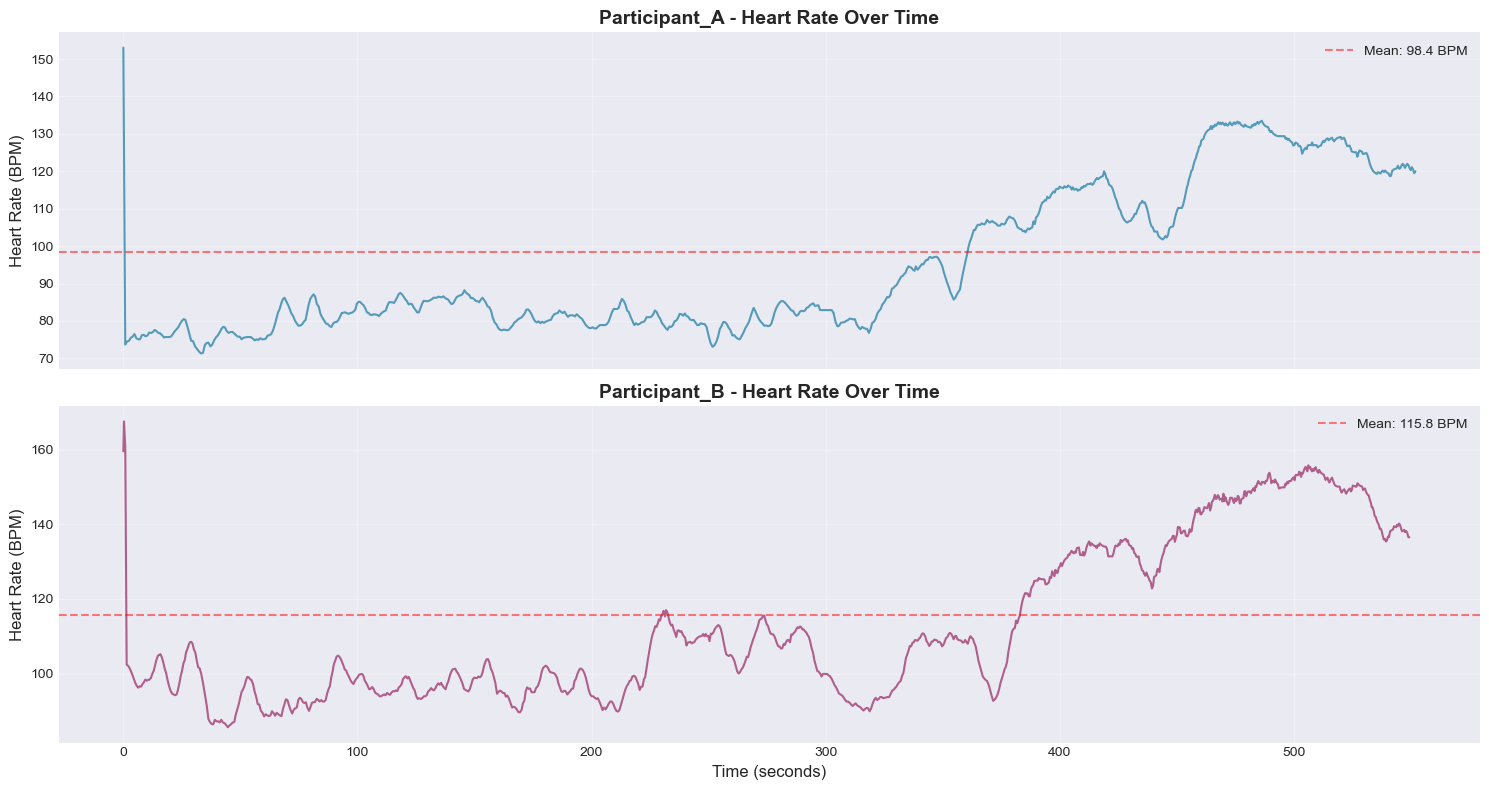

In [5]:
def plot_hr_timeseries(hr_df1, hr_df2, p1_name, p2_name):
    """
    Plot heart rate time series for both participants.
    """
    fig, axes = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
    
    # Participant 1
    axes[0].plot(hr_df1['Time_s'], hr_df1['Average'], 
                 linewidth=1.5, color='#2E86AB', alpha=0.8)
    axes[0].axhline(hr_df1['Average'].mean(), color='red', 
                    linestyle='--', alpha=0.5, label=f"Mean: {hr_df1['Average'].mean():.1f} BPM")
    axes[0].set_ylabel('Heart Rate (BPM)', fontsize=12)
    axes[0].set_title(f'{p1_name} - Heart Rate Over Time', fontsize=14, fontweight='bold')
    axes[0].legend(loc='upper right')
    axes[0].grid(True, alpha=0.3)
    
    # Participant 2
    axes[1].plot(hr_df2['Time_s'], hr_df2['Average'], 
                 linewidth=1.5, color='#A23B72', alpha=0.8)
    axes[1].axhline(hr_df2['Average'].mean(), color='red', 
                    linestyle='--', alpha=0.5, label=f"Mean: {hr_df2['Average'].mean():.1f} BPM")
    axes[1].set_xlabel('Time (seconds)', fontsize=12)
    axes[1].set_ylabel('Heart Rate (BPM)', fontsize=12)
    axes[1].set_title(f'{p2_name} - Heart Rate Over Time', fontsize=14, fontweight='bold')
    axes[1].legend(loc='upper right')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_hr_timeseries(hr_p1_ts, hr_p2_ts, metadata['participant_1'], metadata['participant_2'])

## 5. Overlaying Heart Rates for Visual Comparison

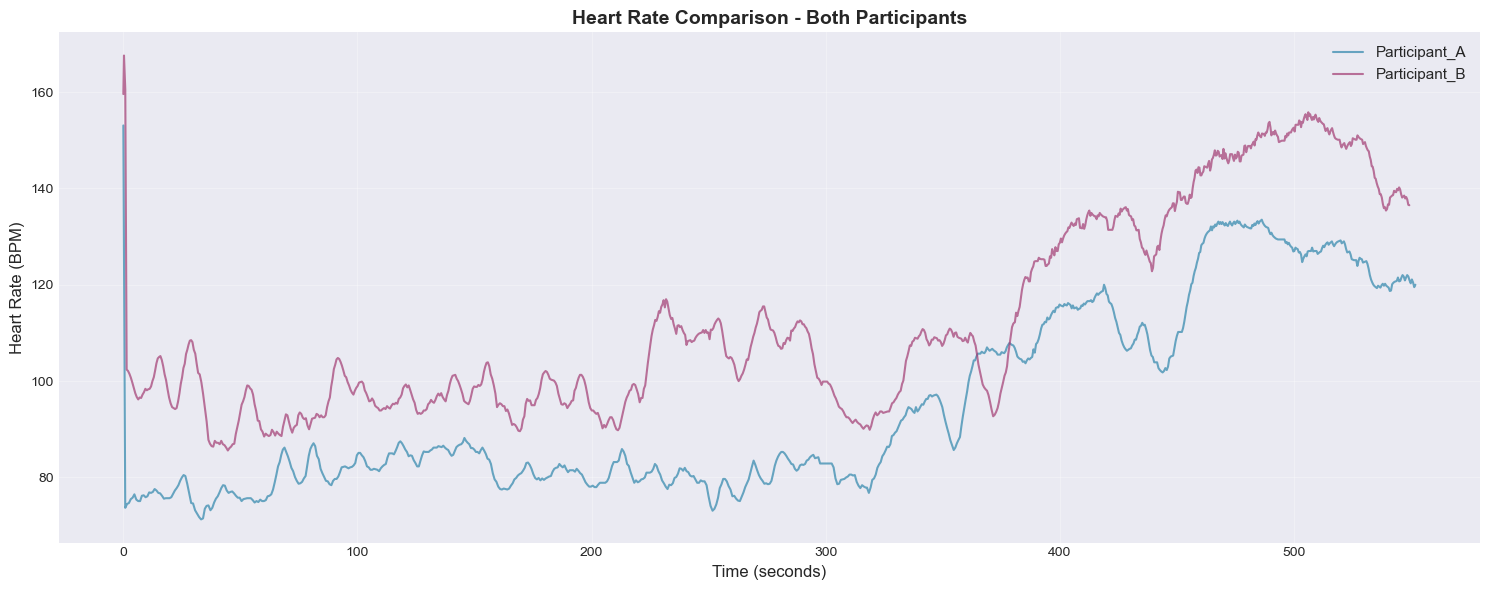


👀 Visual Inspection:
  Look for:
    - Overall trends (increasing/decreasing together?)
    - Moments of similar patterns
    - Time-lagged relationships


In [6]:
def plot_hr_overlay(hr_df1, hr_df2, p1_name, p2_name):
    """
    Plot both participants' heart rates on the same axes for comparison.
    """
    fig, ax = plt.subplots(figsize=(15, 6))
    
    ax.plot(hr_df1['Time_s'], hr_df1['Average'], 
            linewidth=1.5, color='#2E86AB', alpha=0.7, label=p1_name)
    ax.plot(hr_df2['Time_s'], hr_df2['Average'], 
            linewidth=1.5, color='#A23B72', alpha=0.7, label=p2_name)
    
    ax.set_xlabel('Time (seconds)', fontsize=12)
    ax.set_ylabel('Heart Rate (BPM)', fontsize=12)
    ax.set_title('Heart Rate Comparison - Both Participants', fontsize=14, fontweight='bold')
    ax.legend(loc='upper right', fontsize=11)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n👀 Visual Inspection:")
    print("  Look for:")
    print("    - Overall trends (increasing/decreasing together?)")
    print("    - Moments of similar patterns")
    print("    - Time-lagged relationships")

plot_hr_overlay(hr_p1_ts, hr_p2_ts, metadata['participant_1'], metadata['participant_2'])

## 6. Synchrony Analysis: Correlation

Now let's quantify the relationship between the two participants' heart rates.

### Correlation Basics:

**Pearson Correlation (r)**: Measures linear relationship between two variables
- Range: -1 to +1
- +1: Perfect positive correlation (move together)
- 0: No linear relationship
- -1: Perfect negative correlation (move oppositely)

**Interpretation for physiological synchrony:**
- |r| > 0.7: Strong synchrony
- |r| > 0.4: Moderate synchrony
- |r| > 0.2: Weak synchrony
- |r| < 0.2: Little to no synchrony

In [7]:
def compute_correlation(hr1, hr2):
    """
    Compute Pearson correlation between two heart rate time series.
    
    Returns correlation coefficient and p-value.
    """
    # Ensure both series have the same length (use shorter one)
    min_len = min(len(hr1), len(hr2))
    hr1_trimmed = hr1[:min_len]
    hr2_trimmed = hr2[:min_len]
    
    # Compute correlation
    r, p_value = stats.pearsonr(hr1_trimmed, hr2_trimmed)
    
    return r, p_value, min_len

# Compute overall correlation
r, p_val, n_samples = compute_correlation(
    hr_p1_ts['Average'].values, 
    hr_p2_ts['Average'].values
)

print("=" * 60)
print("HEART RATE SYNCHRONY - Overall Correlation")
print("=" * 60)
print(f"\nPearson correlation (r): {r:.3f}")
print(f"P-value: {p_val:.4e}")
print(f"Number of samples: {n_samples}")

# Interpret the result
if abs(r) > 0.7:
    strength = "STRONG"
elif abs(r) > 0.4:
    strength = "MODERATE"
elif abs(r) > 0.2:
    strength = "WEAK"
else:
    strength = "LITTLE TO NO"

direction = "positive" if r > 0 else "negative"
significant = "significant" if p_val < 0.05 else "not significant"

print(f"\n📊 Interpretation:")
print(f"   {strength} {direction} correlation")
print(f"   Result is statistically {significant} (α = 0.05)")

HEART RATE SYNCHRONY - Overall Correlation

Pearson correlation (r): 0.775
P-value: 4.5960e-175
Number of samples: 871

📊 Interpretation:
   STRONG positive correlation
   Result is statistically significant (α = 0.05)


## 7. Scatter Plot: HR Correlation

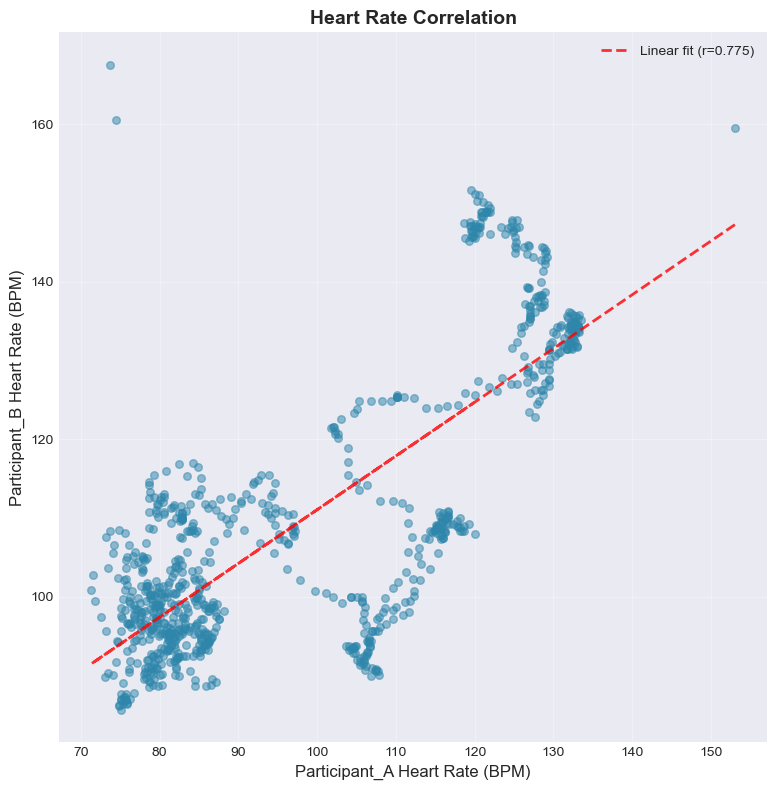

In [8]:
def plot_hr_scatter(hr1, hr2, p1_name, p2_name, r_value):
    """
    Create scatter plot of heart rates from both participants.
    """
    min_len = min(len(hr1), len(hr2))
    
    fig, ax = plt.subplots(figsize=(8, 8))
    
    ax.scatter(hr1[:min_len], hr2[:min_len], alpha=0.5, s=30, color='#2E86AB')
    
    # Add regression line
    z = np.polyfit(hr1[:min_len], hr2[:min_len], 1)
    p = np.poly1d(z)
    ax.plot(hr1[:min_len], p(hr1[:min_len]), "r--", alpha=0.8, linewidth=2, 
            label=f'Linear fit (r={r_value:.3f})')
    
    ax.set_xlabel(f'{p1_name} Heart Rate (BPM)', fontsize=12)
    ax.set_ylabel(f'{p2_name} Heart Rate (BPM)', fontsize=12)
    ax.set_title('Heart Rate Correlation', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Make it square
    ax.set_aspect('equal', adjustable='box')
    
    plt.tight_layout()
    plt.show()

plot_hr_scatter(
    hr_p1_ts['Average'].values, 
    hr_p2_ts['Average'].values,
    metadata['participant_1'], 
    metadata['participant_2'],
    r
)

## 8. Windowed Synchrony Analysis

Instead of computing a single correlation for the entire recording, let's look at how synchrony changes over time.

### Windowed Analysis:

We split the time series into overlapping windows and compute correlation for each window. This reveals:
- Temporal dynamics of synchrony
- Moments of high/low coordination
- Transitions in physiological coupling

In [10]:
def windowed_correlation(hr1, hr2, window_size_sec=30, overlap=0.5):
    """
    Compute correlation in sliding windows.
    
    Parameters:
    - window_size_sec: Window size in seconds
    - overlap: Fraction of overlap between windows (0-1)
    
    Returns:
    - window_centers: Time points for each window
    - correlations: Correlation values for each window
    """
    min_len = min(len(hr1), len(hr2))
    hr1 = hr1[:min_len]
    hr2 = hr2[:min_len]
    
    # Estimate sampling rate (samples per second)
    duration = metadata['duration_seconds']
    sampling_rate = len(hr1) / duration
    
    # Convert window size to samples
    window_size = int(window_size_sec * sampling_rate)
    step_size = int(window_size * (1 - overlap))
    
    correlations = []
    window_centers = []
    
    for start in range(0, len(hr1) - window_size, step_size):
        end = start + window_size
        
        # Extract window
        window1 = hr1[start:end]
        window2 = hr2[start:end]
        
        # Compute correlation
        r, _ = stats.pearsonr(window1, window2)
        correlations.append(r)
        
        # Calculate center time of window
        center_time = ((start + end) / 2) / sampling_rate
        window_centers.append(center_time)
    
    return np.array(window_centers), np.array(correlations)

# Compute windowed correlation
window_size = 30  # seconds
print(f"Computing windowed correlation (window size: {window_size}s)...")

times, correlations = windowed_correlation(
    hr_p1_ts['Average'].values,
    hr_p2_ts['Average'].values,
    window_size_sec=window_size,
    overlap=0.5
)

print(f"✓ Computed {len(correlations)} windows")
print(f"\nSynchrony statistics:")
print(f"  Mean correlation: {correlations.mean():.3f}")
print(f"  Std correlation:  {correlations.std():.3f}")
print(f"  Min correlation:  {correlations.min():.3f}")
print(f"  Max correlation:  {correlations.max():.3f}")

Computing windowed correlation (window size: 30s)...
✓ Computed 35 windows

Synchrony statistics:
  Mean correlation: 0.195
  Std correlation:  0.508
  Min correlation:  -0.926
  Max correlation:  0.968


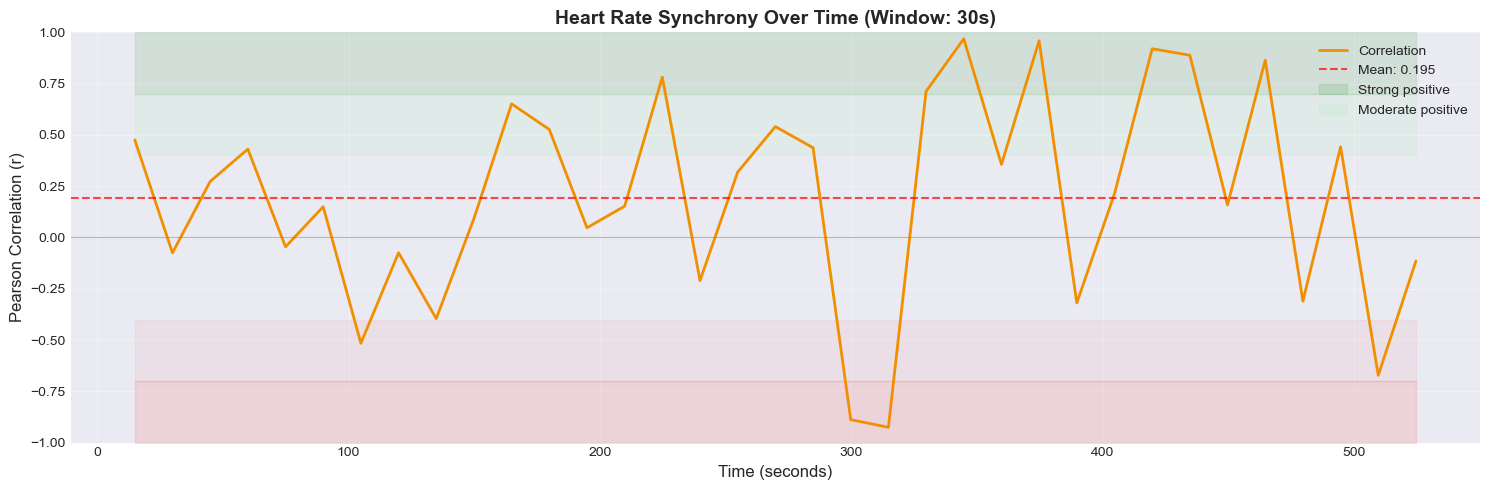

In [11]:
def plot_windowed_correlation(times, correlations, window_size):
    """
    Plot the windowed correlation over time.
    """
    fig, ax = plt.subplots(figsize=(15, 5))
    
    # Plot correlation line
    ax.plot(times, correlations, linewidth=2, color='#F18F01', label='Correlation')
    
    # Add reference lines
    ax.axhline(0, color='gray', linestyle='-', linewidth=0.8, alpha=0.5)
    ax.axhline(correlations.mean(), color='red', linestyle='--', 
               linewidth=1.5, alpha=0.7, label=f'Mean: {correlations.mean():.3f}')
    
    # Shade regions by strength
    ax.fill_between(times, 0.7, 1.0, alpha=0.1, color='green', label='Strong positive')
    ax.fill_between(times, 0.4, 0.7, alpha=0.1, color='lightgreen', label='Moderate positive')
    ax.fill_between(times, -0.4, -0.7, alpha=0.1, color='lightcoral')
    ax.fill_between(times, -0.7, -1.0, alpha=0.1, color='red')
    
    ax.set_xlabel('Time (seconds)', fontsize=12)
    ax.set_ylabel('Pearson Correlation (r)', fontsize=12)
    ax.set_title(f'Heart Rate Synchrony Over Time (Window: {window_size}s)', 
                 fontsize=14, fontweight='bold')
    ax.set_ylim(-1, 1)
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_windowed_correlation(times, correlations, window_size)

## 9. Cross-Correlation Analysis

Cross-correlation helps us understand if one participant's heart rate leads or lags the other.

### Cross-Correlation:

Measures similarity between two time series as a function of the time lag between them.

- **Positive lag**: Participant 1 leads Participant 2
- **Negative lag**: Participant 2 leads Participant 1  
- **Zero lag**: Synchronous (no leader/follower)

This can reveal temporal dynamics in physiological coupling.

In [12]:
def compute_cross_correlation(hr1, hr2, max_lag_sec=30):
    """
    Compute cross-correlation between two heart rate time series.
    
    Parameters:
    - max_lag_sec: Maximum lag to compute in seconds
    
    Returns:
    - lags: Array of lag values (in seconds)
    - correlation: Cross-correlation values
    """
    # Ensure same length
    min_len = min(len(hr1), len(hr2))
    hr1 = hr1[:min_len]
    hr2 = hr2[:min_len]
    
    # Normalize (zero mean, unit variance)
    hr1_norm = (hr1 - hr1.mean()) / hr1.std()
    hr2_norm = (hr2 - hr2.mean()) / hr2.std()
    
    # Compute cross-correlation
    correlation = signal.correlate(hr1_norm, hr2_norm, mode='same')
    correlation = correlation / len(hr1_norm)  # Normalize
    
    # Create lag array
    duration = metadata['duration_seconds']
    sampling_rate = len(hr1) / duration
    lags = signal.correlation_lags(len(hr1_norm), len(hr2_norm), mode='same')
    lags_sec = lags / sampling_rate
    
    # Limit to max_lag
    mask = np.abs(lags_sec) <= max_lag_sec
    lags_sec = lags_sec[mask]
    correlation = correlation[mask]
    
    # Find peak
    max_corr_idx = np.argmax(correlation)
    max_corr = correlation[max_corr_idx]
    max_lag = lags_sec[max_corr_idx]
    
    return lags_sec, correlation, max_lag, max_corr

# Compute cross-correlation
lags, xcorr, max_lag, max_corr = compute_cross_correlation(
    hr_p1_ts['Average'].values,
    hr_p2_ts['Average'].values,
    max_lag_sec=30
)

print("=" * 60)
print("CROSS-CORRELATION ANALYSIS")
print("=" * 60)
print(f"\nMaximum correlation: {max_corr:.3f}")
print(f"Occurs at lag: {max_lag:.2f} seconds")

if abs(max_lag) < 1:
    print("\n📊 Interpretation: Synchronous (no significant lag)")
elif max_lag > 0:
    print(f"\n📊 Interpretation: {metadata['participant_1']} leads by {max_lag:.1f}s")
else:
    print(f"\n📊 Interpretation: {metadata['participant_2']} leads by {abs(max_lag):.1f}s")

CROSS-CORRELATION ANALYSIS

Maximum correlation: 0.783
Occurs at lag: -1.25 seconds

📊 Interpretation: Participant_B leads by 1.2s


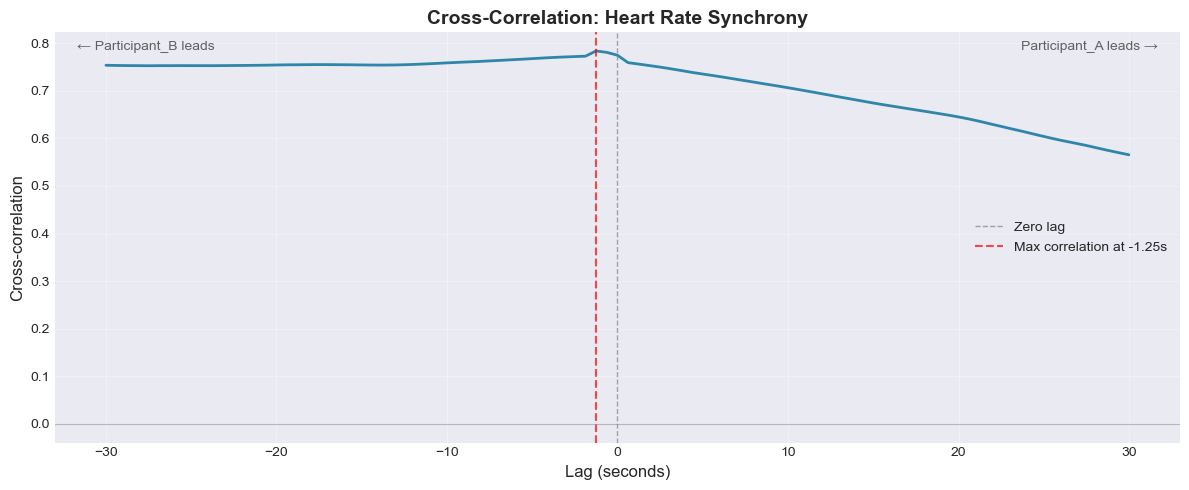

In [13]:
def plot_cross_correlation(lags, xcorr, max_lag, max_corr, p1_name, p2_name):
    """
    Plot cross-correlation function.
    """
    fig, ax = plt.subplots(figsize=(12, 5))
    
    ax.plot(lags, xcorr, linewidth=2, color='#2E86AB')
    ax.axvline(0, color='gray', linestyle='--', linewidth=1, alpha=0.7, label='Zero lag')
    ax.axvline(max_lag, color='red', linestyle='--', linewidth=1.5, alpha=0.7,
               label=f'Max correlation at {max_lag:.2f}s')
    ax.axhline(0, color='gray', linestyle='-', linewidth=0.8, alpha=0.5)
    
    ax.set_xlabel('Lag (seconds)', fontsize=12)
    ax.set_ylabel('Cross-correlation', fontsize=12)
    ax.set_title('Cross-Correlation: Heart Rate Synchrony', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Add annotations
    ax.text(0.02, 0.98, f'← {p2_name} leads', transform=ax.transAxes, 
            fontsize=10, verticalalignment='top', alpha=0.7)
    ax.text(0.98, 0.98, f'{p1_name} leads →', transform=ax.transAxes, 
            fontsize=10, verticalalignment='top', horizontalalignment='right', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

plot_cross_correlation(lags, xcorr, max_lag, max_corr, 
                       metadata['participant_1'], metadata['participant_2'])

## 10. Summary and Comparison with Full Pipeline

Let's summarize what we've found with the quick pipeline.

In [14]:
print("=" * 70)
print("QUICK PIPELINE SUMMARY")
print("=" * 70)

print(f"\n📊 Participants: {metadata['participant_1']} & {metadata['participant_2']}")
print(f"⏱️  Duration: {metadata['duration_seconds']:.1f} seconds ({metadata['duration_seconds']/60:.1f} minutes)")

print(f"\n💓 Mean Heart Rates:")
print(f"   {metadata['participant_1']}: {hr_p1_ts['Average'].mean():.1f} ± {hr_p1_ts['Average'].std():.1f} BPM")
print(f"   {metadata['participant_2']}: {hr_p2_ts['Average'].mean():.1f} ± {hr_p2_ts['Average'].std():.1f} BPM")

print(f"\n🔗 Overall Synchrony (Correlation):")
print(f"   Pearson r: {r:.3f}")
print(f"   P-value: {p_val:.4e}")
print(f"   Strength: {strength}")

print(f"\n⏰ Temporal Dynamics (Windowed):")
print(f"   Mean correlation: {correlations.mean():.3f}")
print(f"   Variability (std): {correlations.std():.3f}")
print(f"   Range: [{correlations.min():.3f}, {correlations.max():.3f}]")

print(f"\n↔️  Cross-Correlation:")
print(f"   Max correlation: {max_corr:.3f}")
print(f"   Optimal lag: {max_lag:.2f} seconds")

if abs(max_lag) < 1:
    leader_text = "Synchronous (no clear leader)"
elif max_lag > 0:
    leader_text = f"{metadata['participant_1']} tends to lead"
else:
    leader_text = f"{metadata['participant_2']} tends to lead"
print(f"   Leader: {leader_text}")

print("\n" + "=" * 70)
print("\nQuick Pipeline Complete!")
print("\n📚 What's Next:")
print("   → Notebook 3: Full ECG preprocessing pipeline")
print("     - ECG signal cleaning with NeuroKit2")
print("     - R-peak detection")
print("     - Detailed HRV analysis (time & frequency domain)")
print("     - Advanced synchrony metrics")
print("\n Compare results to see differences between pipelines!")

QUICK PIPELINE SUMMARY

📊 Participants: Participant_A & Participant_B
⏱️  Duration: 544.0 seconds (9.1 minutes)

💓 Mean Heart Rates:
   Participant_A: 98.4 ± 20.1 BPM
   Participant_B: 115.8 ± 21.5 BPM

🔗 Overall Synchrony (Correlation):
   Pearson r: 0.775
   P-value: 4.5960e-175
   Strength: STRONG

⏰ Temporal Dynamics (Windowed):
   Mean correlation: 0.195
   Variability (std): 0.508
   Range: [-0.926, 0.968]

↔️  Cross-Correlation:
   Max correlation: 0.783
   Optimal lag: -1.25 seconds
   Leader: Participant_B tends to lead


Quick Pipeline Complete!

📚 What's Next:
   → Notebook 3: Full ECG preprocessing pipeline
     - ECG signal cleaning with NeuroKit2
     - R-peak detection
     - Detailed HRV analysis (time & frequency domain)
     - Advanced synchrony metrics

 Compare results to see differences between pipelines!


---

## Try It Yourself!

### Exercise 1: Different Window Sizes
Try changing the `window_size` parameter in the windowed correlation analysis:
- Smaller windows (e.g., 10s): More temporal detail but noisier
- Larger windows (e.g., 60s): Smoother but less detail

### Exercise 2: Alternative Synchrony Metrics
Try implementing other synchrony measures:
- Spearman correlation (rank-based, less sensitive to outliers)
- Mutual information (captures nonlinear relationships)
- Dynamic Time Warping distance

### Exercise 3: Segment Analysis
If your experiment has different phases, try computing synchrony separately for each phase.

---

## Notebook 2 Complete!

You've successfully:
- Loaded and visualized pre-computed heart rate data
- Computed overall correlation between participants
- Analyzed temporal dynamics with windowed correlation
- Investigated leader-follower relationships with cross-correlation

**Next**: Notebook 3 - Full ECG Preprocessing Pipeline 